# Ambient Noise Signal Processing Detector
__Contributors:__ Bilguun Bulgan, Coraline Sun, Caitlyn Liu, Isaac Castillo
<br>__Instructors:__ Ryan Kastner, Perry Naughton 
<br>__Description:__ This project is a part of the UC San Diego Early Scholars Research Program (ERSP). This detector was built particularly to detect the signals of the snapping shrimp of the La Jolla shore waters. The detector takes in a sound file, calcuates the frequencies with the Fourier Transformation, then returns a "snap" as a unit. The snap should have comprehensive attributes of a sound wave, including the direct arrival of the snap, and its corresponding reflected waves. 
    

This is "Part 1" of our project, where we analyze data on primarly, single files.

In [18]:
import numpy as np

from scipy.io.wavfile import read
from scipy import signal, arange
from scipy.signal import hilbert, chirp
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.axes as matax
import matplotlib.mlab as mlab
import matplotlib.patches as patches

First, we need to load the file, and gather all the necessary details. We are working primarily with a sampling frequency of 65501Hz, and a file of about 15-20 minutes. 

After loading the file, we want to setup some default variables that will help us operate on the data. 

In [19]:
sampFreq, sound = read('wav1.wav');

In [20]:
#taking 5 seconds of sample from 15s - 20sec in file 
#interval have 100 frames towards left and 400 frames towards right
initTime = 0;    # the start time
duration = 5;     # duration of time period start at initTime



Our first task is to make a spectrogram of the sound data. A spectrogram is a graph which represents the presence of frequences in our sound files.

our function graphSpectrogram will take in some arguments: A sound snippet, a time-axis, and an axes to plot on. 
We will need a time array to represent the x-axis. Let's make a function to do that.

We also want to have a function that can take a snippet of our entire sound file. 


In [21]:
#start - the initial time(in seconds) of the sound snippet we want an x-axis of
#duration - the duration(in seconds) of the sound snippet
#samp - the sampling frequency of the sound file we are operating on. Default is sampFreq, our constant. 
def timeArray(start, duration, samp=sampFreq):
    start = samp * start;
    end = start + samp * duration;
    time = np.arange(0, end-start, 1)
    time = time

    return time/samp

#samp - the sampling frequency of the sound file we are operating on
#start - the initial time(in seconds) of the sound snippet we want an x-axis of
#duration - the duration(in seconds) of the sound snippet
def getSnippet(entire, start, duration, samp=sampFreq):
    start = samp * initTime;
    end = start + samp * duration;
    snip = entire[start:end];
    
    return snip

From these two functions, we can create a amplitude display of our data.

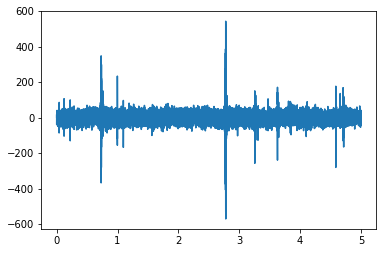

In [22]:
time = timeArray(initTime, duration)
snip = getSnippet(sound, initTime, duration)

plt.plot(time, snip)
plt.show();

Now, we create code for to displaya a spectrogram. We want to be able to label (annotate) the signals identified when given as indices, shown below.

In [33]:
def graphSpectrogram(snip, time, ax=plt, snaps=None, pings=None, undef=None):
    fig = ax.figure(figsize=(8,3));
    f, t, Sxx = signal.spectrogram(snip, sampFreq, nperseg=256)
    im = ax.pcolormesh(t, f/1000, np.log(Sxx), cmap='jet')
    if(snaps != None):
        for i in snaps:
            ax.annotate("snap", xy=(i, 15), xytext=(i, 25), color='black', arrowprops=dict(facecolor='black', shrink=0.05), fontsize=17)
    if(pings != None):
        for i in pings:
            ax.annotate("ping", xy=(i, 5), xytext=(i, -4.4), color='black', arrowprops=dict(facecolor='black', shrink=0.05), fontsize=17)
    if(undef != None):
        for i in undef:
            ax.annotate("undefined", xy=(i, 4), xytext=(i, -4.4), color='black', arrowprops=dict(facecolor='black', shrink=0.05), fontsize=17)
    im.set_clim(-10, 0)
    ax.ylim(0,20)
    cb = plt.colorbar(mappable = im, ticks = [0, -2, -4, -6, -8, -10])
    ax.ylabel('Frequency [kHz]')
    ax.ylim(0,20)
    ax.xlim(0, duration);
    ax.xlabel('Time (s)')
    ax.rc('xtick', labelsize=16) 
    ax.rc('ytick', labelsize=16) 
    ax.rc('axes', titlesize=22)     # fontsize of the axes title
    plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
    locs, labels = ax.xticks()
    ax.xticks(locs[1:])
    cb.set_label('signal intensity', rotation=0, fontsize=16, labelpad=0, y = 1.15)
    ax.margins(x=0)
    im.set_clim(-10, 0)
    mappable = im



We show an example of a spectrogram without annotations.

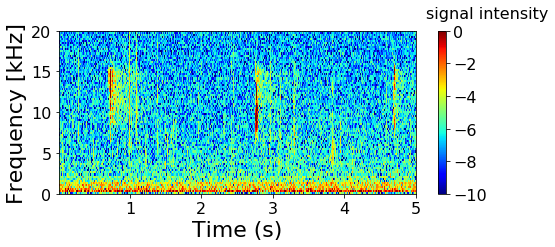

In [25]:
graphSpectrogram(snip,time)

We believe that the red areas are signals from floating buoyings, and the "long yellow" lines are snaps from shrimp.

Lets see if this is actually the case.

We want to identify the signals of the snaps, and the pings, through computer code, and eventually attach a label as described above.

To do this, we want to be able to identify a "signal". We consider a signal, any set of points over a certain amplitude.

In [26]:
windowSize = 0.1
def getSignals(snip, time, dev):
    thres = np.std(snip) * dev
    aboveThres = snip > thres 
    signals = []
    
    # current = the first time frame has amplitude above threshold
    # snaps = the time where each loud signal above threshold
    # snapIndex = the time frame indices of each loud signal above threshold
    current = time[aboveThres][0] 
    signals.append(int(current * sampFreq))

    # set a 0.01sec time window that slides across the current array
    # so that we only collect one time data for each loud signal
    for t in time[aboveThres]: 

        if (t > current + windowSize ):
            signals.append(int((t * sampFreq)))
            current = t
    return signals

In [27]:
signals = getSignals(snip, time, 6) #5 Deviations
print(signals)

[47571, 65318, 181044, 213188, 237600, 300361, 307942]


We got some signals, and we want to see what they look like. 

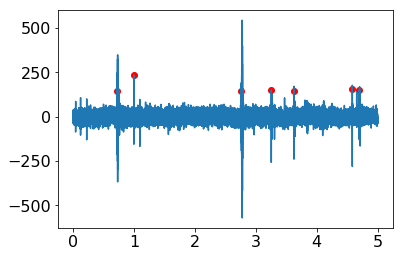

In [28]:
plt.scatter(time[signals], snip[signals], c='red')
plt.plot(time, snip)
plt.show();

The red dots represent signals. Clearly, they are above a certain threshold. Lets see what they look like up close. We expect "pings" to be longer, and "snaps" to be shorter. 

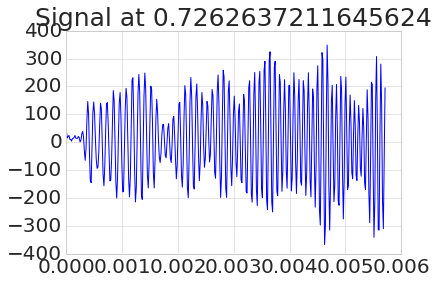

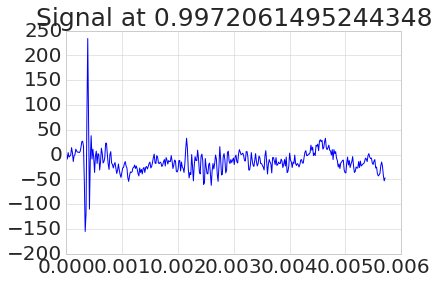

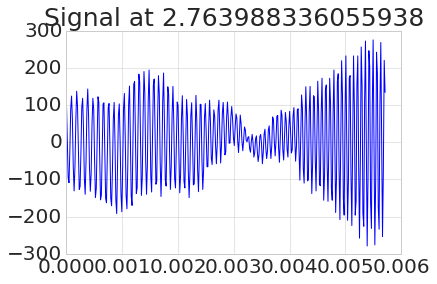

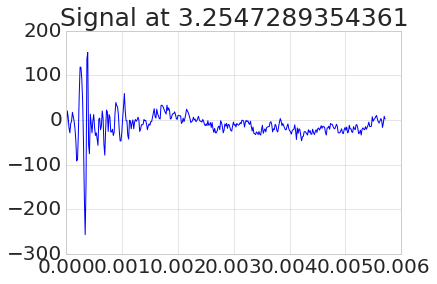

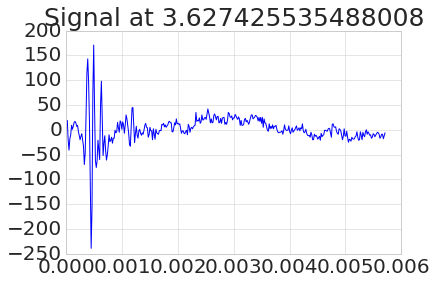

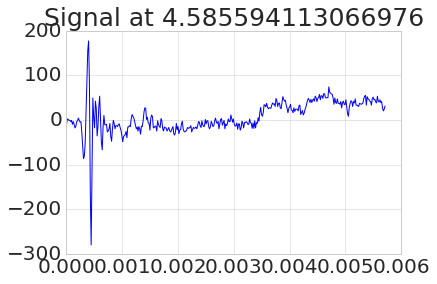

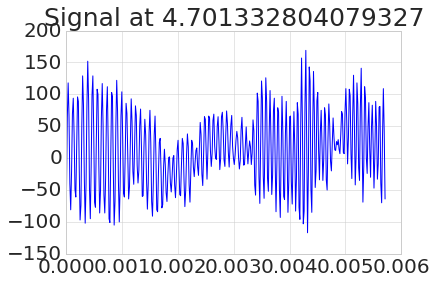

In [11]:
for i in signals:
  s = int(i-25)
  e = int(i+350)
  t = np.arange(0, e-s, 1)
  t = t / sampFreq
  mini = snip[s:e];
  plt.plot(t, mini)
  plt.title("Signal at " + str(i/sampFreq))
  plt.show()

Lets see where this corresponds on the spectrogram. First, lets attempt to classify them automatically.

To do this, we want to compare the ratio of frequencies present in the "mini snippet". 

First, we need to be able to identify the frequency of the signals present in each signal, then, we want to get the ratio of frequencies in a range. Upon doing this, we analyze the ratio of frequencies and classify. We can plot the frequencies present for each signal as well. 

The code for all the previous is listed below.

In [30]:
def getFrequencies(signal):
    length = len(signal) # length of the signal
    #k = arange(length)
    #T = length/sampFreq
    #frq = k/T # two sides frequency range
    #frq = frq[range(np.int(length/2))] # one side frequency range

    frequencies = np.fft.fft(signal)/length # fft computing and normalization
    frequencies = frequencies[range(np.int(length/2))]
    
    return abs(frequencies)

def getRatio(signal):
    frequencies = getFrequencies(signal)
    ratio = sum(frequencies[34:68] * 100/sum(frequencies)) #Gets the correct ratio of frequencies.  
    return ratio;

def classify(signal):  
    ratio = getRatio(signal)
    if (ratio > 70):
        return "Ping"
    
    elif (ratio < 50):
        return "Snap"
    else:
        return "Undefined"
    
def plotFrequencies(signal, ax):
    length = len(signal) # length of the signal
    k = arange(length)
    T = length/sampFreq
    frq = k/T # two sides frequency range
    frq = frq[range(np.int(length/2))] # one side frequency range
 
    
    ax.plot(frq, getFrequencies(signal),'r') # plotting the spectrum

    ax.xlabel('Freq (Hz)')
    ax.ylabel('|Y(freq)|')
    ax.show();

In [36]:
#This function gets the Pings and the Snaps
#signals - Array of indices at which a "signal" begins. 
#back - How far back to go, in milliseconds. 
#forward - How far forward to go in milliseconds.

#Sample: 20ms is about 1310 indicies
def getPingsAndSnaps(signals):
    snaps = []
    pings = []
    undef = []
    for i in signals:
      s = int(i-25)
      e = int(i+250)
      t = np.arange(0, e-s, 1)
      t = t / sampFreq
      mini = snip[s:e];
      #print(s, e, getRatio(mini))
      res = classify(mini)
    #  plt.plot(t, mini);
    #  plt.show();
    #  plotFrequencies(mini, plt);
      
      if(res == "Snap"):
        snaps.append(i/sampFreq)
      elif(res == "Ping"):
        pings.append(i/sampFreq)
      else:
        undef.append(i/sampFreq)

    return (pings, snaps, undef)


Conclusion: We have an example shown below. We look at the sound present from 2 seconds to 5 seconds, and attempt to identify all the types of signals present.

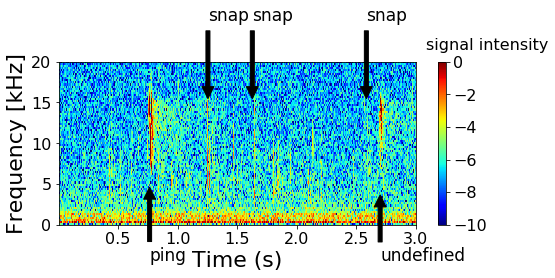

In [37]:
#interval have 100 frames towards left and 400 frames towards right
initTime = 2;    # the start time
duration = 3;     # duration of time period start at initTime
time = timeArray(initTime, duration)
snip = getSnippet(sound, initTime, duration)
signals = getSignals(snip, time, 6) #5 Deviations
(pings, snaps, undef) = getPingsAndSnaps(signals)

graphSpectrogram(snip, time, pings=pings, snaps=snaps, undef=undef)

As we can see, we can are able to correctly identify the pings and snaps, correctly, for the most part. However, we cannot identify that final ping at the left. This is because it appears to overlap with a snap.

Now that we can correctly identify signals, we are interested in only using snaps in our research(for the most part).

Now, we are interested being able to see reflected waves, from the snap signals. By our previous method, we have the times of snaps, but we want actual signals. Where will these reflected waves even show up?

From a geometric analysis, we can see depending on how far a shrimp is from the recording auv, and how deep the ocean is, we will have a range to look at. The following code is not really parsable to the uninitiated, but its just essentially using similar triangles. In this assumption, we have that the waves reflect off the top and bottom surface smoothly using angles of reflections.

More details: If we keep the depth of the ocean constant, a shrimp existing on the ocean floor will emit a snap. If the sound wave of the snap reaches an AUV, we can know precisely where it reflected off the ocean surface, and the ocean floor( for both single-reflection, and double-reflection arrivals), assuming the ocean floor/surface is flat. We also assume that since it is flat, the angle of reflection does not change. 

## This is a useful tool, because it gives a model to recover the location of a shrimp given a known depth, and the presence of single-reflected/double-reflected arrivals.


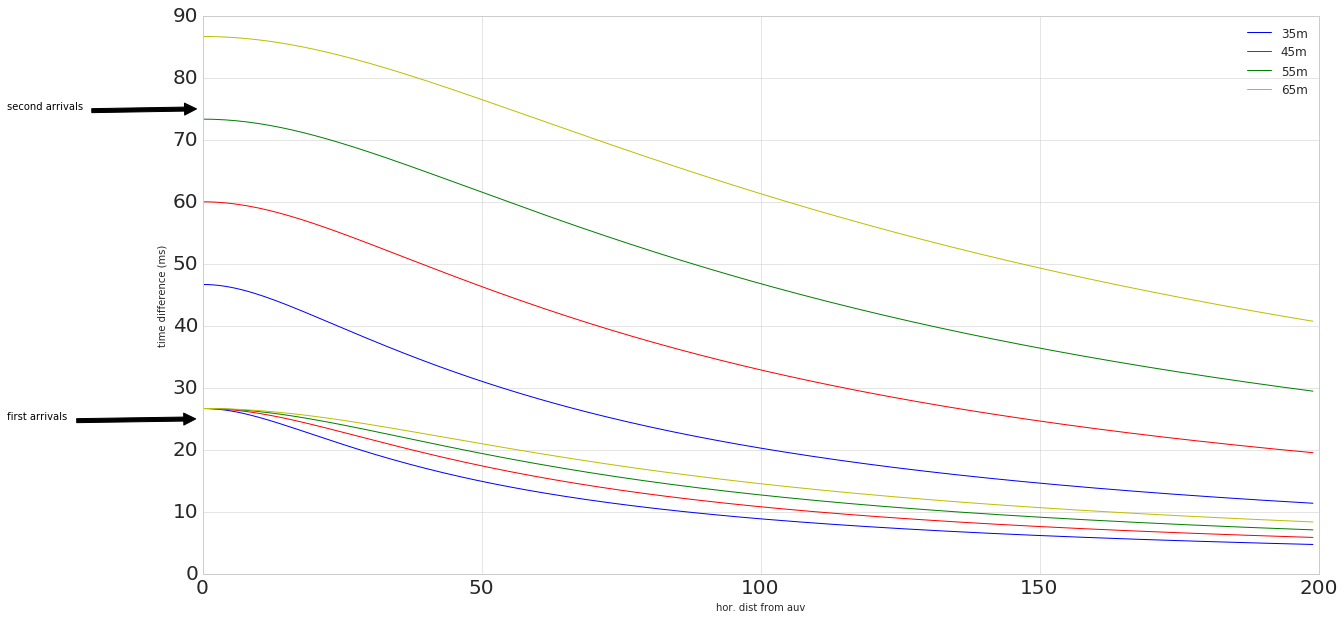

In [15]:
oceanDepth = 50
auvDepth = 20

def dirDist(x, auvDepth=auvDepth, oceanDepth=oceanDepth):
    return np.sqrt(x**2 + (oceanDepth - auvDepth) ** 2)

def refDist(x, auvDepth=auvDepth, oceanDepth=oceanDepth):
    return np.sqrt(oceanDepth**2  + ref1helper(x)**2) + np.sqrt(auvDepth**2 + (x-ref1helper(x))**2)
    
def ref1helper(x, auvDepth=auvDepth, oceanDepth=oceanDepth):
    return oceanDepth*x/(oceanDepth + auvDepth)

def ref2Dist(x, auvDepth=auvDepth, oceanDepth=oceanDepth):
    return 2 * np.sqrt(oceanDepth**2 + ref2helper(x)**2) + np.sqrt((oceanDepth-auvDepth)**2 + (x-2*ref2helper(x))**2)

def ref2helper(x, auvDepth=auvDepth, oceanDepth=oceanDepth):
    return oceanDepth*x/(3*oceanDepth-auvDepth)

def firTimeDist(x, auvDepth=auvDepth, oceanDepth=oceanDepth):
    return refDist(x, auvDepth, oceanDepth) - dirDist(x, auvDepth, oceanDepth)

def secTimeDist(x, auvDepth=auvDepth, oceanDepth=oceanDepth):
    return ref2Dist(x, auvDepth, oceanDepth) - dirDist(x, auvDepth, oceanDepth)

firstArrival = []
secondArrival = []
xdist = 200
plt.figure(figsize=(20,10))
color = ["b", "r", "g", "y"]
index=0
for j in range(35, 75, 10):
    for i in range(xdist):
        firstArrival.append(firTimeDist(i, 20, j)*2/3);
        secondArrival.append(secTimeDist(i, 20, j)*2/3);
    plt.plot(arange(xdist), firstArrival, c=color[index%4]);
    plt.plot(arange(xdist), secondArrival, label=str(j)+"m", c=color[index%4]);
    firstArrival = []
    secondArrival = []
    index = index+1;

plt.legend()
plt.annotate("first arrivals", xy=(0, 25), xytext=(-35, 25), color='black', arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("second arrivals", xy=(0,75), xytext=(-35, 75), color='black', arrowprops=dict(facecolor='black', shrink=0.05))

plt.xlabel("hor. dist from auv");
plt.ylabel("time difference (ms)");
plt.show();

This concludes the first part of our research. Now a concern is 1. Translating this model into 3D 2. Identifying single-reflected and double-reflected waves in our sound file. 3. Correctly associating each direct arrival with a reflected arrival.  